In [38]:
import numpy as np
import pandas as pd
from pycytominer.cyto_utils import infer_cp_features
import sys
import matplotlib.pyplot as plt
sys.path.insert(0, "../../scripts")
from utils import load_data
from tensorflow import keras
from scipy.stats import pearsonr, ttest_ind, ttest_1samp

import seaborn as sns
from sklearn.decomposition import PCA
import random
import scipy

In [39]:
np.random.seed(82)
NUM_RANDOM_SAMPLES = 1

In [40]:
data_dict = load_data(["complete"])
meta_features = infer_cp_features(data_dict["complete"], metadata=True)
cp_features = infer_cp_features(data_dict["complete"])

complete_features_df = data_dict["complete"].reindex(cp_features, axis="columns")
complete_meta_df = data_dict["complete"].reindex(meta_features, axis="columns")

In [41]:
moas_occurrence = pd.read_csv("moas_occurrence.tsv", sep = "\t")
moas_occurrence.index = moas_occurrence['moa']
moas_occurrence = moas_occurrence.drop('moa', axis = 1)

valid_pipes = moas_occurrence[((moas_occurrence != 0).all(axis = 1)) & (moas_occurrence['full moa occurrence'] > 0) & (moas_occurrence['moa1 occurrence'] > 0)& (moas_occurrence['moa2 occurrence'] > 0)].index
valid_pipes = valid_pipes[valid_pipes.str.count("\|") == 1]

In [42]:
def generate_latent_df(latent_df):
    moa_df = pd.read_csv("repurposing_info_external_moa_map_resolved.tsv",sep='\t').set_index('broad_sample').reindex(index=complete_meta_df['Metadata_broad_sample']).reset_index().drop('Metadata_broad_sample',axis = 1)
#     moa_df.to_csv('moa_metadata.csv')
    meta_moa_latent_df = pd.concat([complete_meta_df,moa_df,latent_df], axis=1)

    # fill negative control DMSO profiles, change the NaN MOA label to be DMSO
    meta_moa_latent_df.loc[meta_moa_latent_df['Metadata_broad_sample'] == 'DMSO', 'moa'] = 'DMSO'

    #drop profiles with NaN MOAs
    meta_moa_latent_df = meta_moa_latent_df.dropna(subset=['moa']).reset_index(drop = True)

    # add columns to the dataframe that are randomnly shuffled permutations of the MOA column
    for i in range(NUM_RANDOM_SAMPLES):
        random_moa_labels = meta_moa_latent_df[['moa']].sample(frac=1).reset_index(drop=True)    
        random_moa_labels = random_moa_labels.rename(columns={'moa': 'random_moa_labels' + str(i)})
        meta_moa_latent_df = pd.concat([random_moa_labels, meta_moa_latent_df], axis=1)
        
    return meta_moa_latent_df

In [43]:
def subset_by_moa(pipe, df_name, column):
    moas = pipe.split("|")
    subset_df = pd.concat([df_name[df_name[column] == moas[0]],df_name[df_name[column] == moas[1]]])
    return subset_df

def LSA(A, B, D):
    return A-D+B

In [44]:
def calculate_means(meta_moa_latent_df, columns):
    subset_means = []
    subset_random_means = []

    for pipe in valid_pipes:
        subset = subset_by_moa(pipe, meta_moa_latent_df, 'moa')
        subset_mean = subset.groupby(['moa'])[columns].mean()

        subsets_random_mean = []
        for i in range(NUM_RANDOM_SAMPLES):
            moa_label = 'random_moa_labels' + str(i)
            subset_random = subset_by_moa(pipe, meta_moa_latent_df, moa_label)
            subset_random_mean = subset_random.groupby([moa_label])[columns].mean()
            subsets_random_mean.append(subset_random_mean)

        subset_means.append(subset_mean)

        subset_random_means.append(subsets_random_mean)
    
    return subset_means, subset_random_means

In [45]:
def calculate_dmso_means(meta_moa_latent_df, columns):
    DMSO = meta_moa_latent_df[meta_moa_latent_df.moa == 'DMSO']
    DMSO_means = np.mean(DMSO[columns])

    DMSO_means_random = []

    for i in range(NUM_RANDOM_SAMPLES):
        label = 'random_moa_labels' + str(i)
        DMSO_random = meta_moa_latent_df[meta_moa_latent_df[label] == 'DMSO']
        DMSO_means_random.append(np.mean(DMSO_random[columns]))
    return DMSO_means, DMSO_means_random

In [46]:
def generate_post_LSA_representations(subset_means, subset_random_means, DMSO_means, DMSO_means_random, latent_df):
    representations_after_LSA = []
    representations_after_LSA_random = []

    for i in range(len(subset_means)):
        
        representation_after_LSA = LSA(subset_means[i].loc[valid_pipes[i].split("|")[0]],subset_means[i].loc[valid_pipes[i].split("|")[1]],DMSO_means)
        representation_after_LSA = pd.DataFrame(representation_after_LSA).transpose()
        representations_after_LSA.append(representation_after_LSA)

        LSA_random_1pipe = []
        for j in range(NUM_RANDOM_SAMPLES):
#             representation_after_LSA_random = LSA(subset_means[i].loc[valid_pipes[i].split("|")[0]],subset_random_means[i][j].loc[valid_pipes[i].split("|")[1]],DMSO_means)
            representation_after_LSA_random = LSA(latent_df.mean(), latent_df.mean(), latent_df.mean())
            representation_after_LSA_random = pd.DataFrame(representation_after_LSA_random).transpose()
            LSA_random_1pipe.append(representation_after_LSA_random)    

        representations_after_LSA_random.append(LSA_random_1pipe)
    
    
    return representations_after_LSA, representations_after_LSA_random

In [47]:
def decode_LSA_representations(representations_after_LSA, representations_after_LSA_random, model, decoder):
    predictions = []
    predictions_random = []
    
    for i in range(len(representations_after_LSA)):

        if model not in ['pca', 'complete']:
            prediction = decoder.predict(representations_after_LSA[i])
        elif model == 'pca':
            prediction = pca.inverse_transform(representations_after_LSA[i])
        elif model == 'complete':    
            prediction = representations_after_LSA[i].values.tolist()
        else:
            print('"model" must be "vae", "pca", or "complete"')
            
        predictions.append(pd.DataFrame(prediction))

        predictions_random_1pipe = []

        for j in range(NUM_RANDOM_SAMPLES):
            if model not in ['pca', 'complete']:
                prediction_random = decoder.predict(representations_after_LSA_random[i][j])
            elif model == 'pca':
                prediction_random = pca.inverse_transform(representations_after_LSA_random[i][j])
            elif model == 'complete':
                prediction_random = representations_after_LSA_random[i][j].values.tolist()
            else:
                print('"model" must be "vae", "pca", or "complete"')

            predictions_random_1pipe.append(prediction_random)


        predictions_random.append(predictions_random_1pipe)

    predictions = np.array(predictions)
    predictions_random = np.array(predictions_random)
    
    return predictions, predictions_random

In [48]:
# calculates all L2 distances for both per MOA combo and general distribution comparison for all MOA combos
meta_moa_complete_df = generate_latent_df(complete_features_df)
def calculate_L2_distances(predictions, predictions_random):
    mean_of_moas = meta_moa_complete_df.groupby(['moa']).mean().loc[:,'Cells_AreaShape_FormFactor':]
    L2 = []
    L2_random = []
    moa_similarity = []
    per_moa_zscore = []
    
    mean = complete_features_df.mean()
    for i in range(len(predictions)):
        desired_moa = np.array(mean_of_moas[(mean_of_moas.index == valid_pipes[i])])
        moa_similarity.append(np.linalg.norm(desired_moa[0] - mean))
        #if L2_distance
        L2_distance = np.linalg.norm(predictions[i]-desired_moa[0])
        #if pearson
#         L2_distance = scipy.stats.pearsonr(predictions[i][0], desired_moa[0])[0]
        L2.append(L2_distance)
        
        L2_random_per_moa = []
        for j in range(NUM_RANDOM_SAMPLES):
            L2_distance_random = np.linalg.norm(predictions_random[i][j][0]-desired_moa[0])
#             L2_distance_random = scipy.stats.pearsonr(predictions_random[i][j][0], desired_moa[0])[0]

            L2_random_per_moa.append(L2_distance_random)

        L2_random += L2_random_per_moa

        zscore = scipy.stats.zscore(L2_random_per_moa + [L2_distance])[-1]
        per_moa_zscore.append(zscore)

    return L2, L2_random, moa_similarity, per_moa_zscore

In [49]:
latent_dim = 10
latent_space_columns = np.arange(0,latent_dim)
latent_space_columns = [str(latent_space_column) for latent_space_column in latent_space_columns]

In [50]:
# latent_names = ["beta","vanilla","mmd","beta_leaveOut","vanilla_leaveOut","mmd_leaveOut","pca","complete"]
# latent_names = ["beta_leaveIntermediateOut","vanilla_leaveIntermediateOut","mmd_leaveIntermediateOut"]
latent_names = ["beta","vanilla","mmd","pca","complete"]


In [51]:
latent_dfs = {}
for latent_name in latent_names:
    if latent_name == "pca":
        pca = PCA(n_components=latent_dim)
        latent_dfs[latent_name] = pd.DataFrame(pca.fit_transform(complete_features_df), columns = latent_space_columns)
    elif latent_name == "complete":
        latent_dfs[latent_name] = complete_features_df
    else:
        latent_dfs[latent_name] = pd.read_csv(f"level5Latent_{latent_name}.csv").drop("Unnamed: 0", axis = 1)

In [52]:
for latent_name in latent_dfs:
    if latent_name == 'complete':
        columns = complete_features_df.columns
    else:
        columns = latent_space_columns
    meta_moa_latent_df = generate_latent_df(latent_dfs[latent_name])
    subset_means, subset_random_means = calculate_means(meta_moa_latent_df, columns)
    DMSO_means, DMSO_means_random  = calculate_dmso_means(meta_moa_latent_df, columns)
    representations_after_LSA, representations_after_LSA_random = generate_post_LSA_representations(subset_means, subset_random_means, DMSO_means, DMSO_means_random, latent_dfs[latent_name])
    decoder = None
    if latent_name not in ['pca', 'complete']:
        decoder = keras.models.load_model(f"../2.train/models/level5Decoder_{latent_name}")        
    predictions, predictions_random = decode_LSA_representations(representations_after_LSA, representations_after_LSA_random, latent_name, decoder)
    L2, L2_random, moa_similarity, per_moa_zscore = calculate_L2_distances(predictions, predictions_random)
    per_moa_performance_df = pd.DataFrame({"MOA":valid_pipes,"zscore":per_moa_zscore,"moa similarity":moa_similarity})
    per_moa_performance_df = per_moa_performance_df.sort_values('zscore')
    per_moa_performance_df.to_csv(f'per_moa_performance/level5_{latent_name}_moa_performanceOnlyOne.csv')
    L2_df = pd.DataFrame(L2, columns = ['Unshuffled'])
    L2_random_df = pd.DataFrame(L2_random, columns = ['Shuffled'])
    L2_df = pd.concat([L2_df, L2_random_df], ignore_index = True, axis = 1)
    L2_df.columns = ['Unshuffled','Shuffled']
    L2_df.to_csv(f'L2_distances/level5_L2_general_{latent_name}OnlyOne.tsv', sep = '\t')

In [58]:
a = pd.read_csv('per_moa_performance/level5_beta_moa_performanceOnlyOne.csv').drop('Unnamed: 0', axis = 1)
a[a.zscore < 0]

,MOA,zscore,moa similarity
0,ATP channel blocker|insulin secretagogue,-1.0,1.062705
1,AKT inhibitor|mTOR inhibitor,-1.0,1.268094
2,histamine receptor agonist|histamine receptor ...,-1.0,1.096773
3,glucocorticoid receptor agonist|immunosuppressant,-1.0,2.007021
4,acetylcholine receptor agonist|benzodiazepine ...,-1.0,1.184401
5,platelet aggregation inhibitor|structural glyc...,-1.0,0.993742
6,leukotriene receptor antagonist|phosphodiester...,-1.0,1.347560
7,DNA alkylating agent|DNA synthesis inhibitor,-1.0,3.704015
8,Aurora kinase inhibitor|JAK inhibitor,-1.0,5.080567
9,microtubule inhibitor|tubulin polymerization i...,-1.0,5.388521


In [53]:
specific_shuffle =  pd.read_csv('L2_distances/level5_L2_general_betaOnlyOne.tsv', sep = '\t').drop('Unnamed: 0', axis = 1)

<AxesSubplot:>

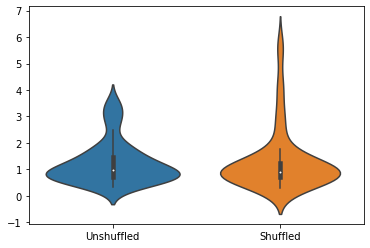

In [54]:
sns.violinplot(data = specific_shuffle)
# specific_shuffle

In [55]:
specific_shuffle.describe()

,Unshuffled,Shuffled
count,84.000000,84.000000
mean,1.246043,1.319835
std,0.804601,1.166439
min,0.345175,0.276223
25%,0.691806,0.722085
50%,0.978387,0.902207
75%,1.460773,1.256473
max,3.545097,5.824819
